In [1]:
"""
Visual Sudoku problem in CPMpy
"""

from cpmpy import * 
import numpy as np 
import torch 
from torchvision import datasets, transforms

from cpmpy.solvers.ortools import CPM_ortools

import matplotlib.pyplot as plt
import urllib.request 
import zipfile


In [ ]:
# #filehandle = 'sudoku.zip'
# url = 'https://powei.tw/sudoku.zip'
# handle, _ = urllib.request.urlretrieve(url)
# zip_file_object = zipfile.ZipFile(handle)




# Solve MNIST "Visual" Sudoku 

In this variant of the Sudoku puzzle, digits are replaced by binary images sampled from [MNIST](http://yann.lecun.com/exdb/mnist/).

Solving a visual Sudoku requires an hybrid approach, combining Machine Learning and Constraint Solving (see [Hybrid Classification and Reasoning for Image-based Constraint Solving](https://doi.org/10.1007/978-3-030-58942-4_24)). 

In [105]:
# Let's build Visual Sudoku problem from MNIST data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the MNIST data
testset = datasets.MNIST('.', download=True, train=False, transform=transform)
# map digit -> corresponding images sample
digit_indices = {k:torch.LongTensor(*np.where(testset.targets == k)) for k in range(1,10)}

N_CHANNEL = 1 # MNIST images are in grey scale 
IMAGE_WIDTH = 28 # MNIST image width
IMAGE_HEIGHT = 28 # MNIST image height


def sample_visual_sudoku(sudoku_puzzle):
    """
        Turn the given `sudoku_puzzle` into a visual puzzle by replace numeric values
        by images from MNIST. 
    """
    # Visual Sudoku Tensor of shape puzzle_width x puzzle_height x n_channel x image_width x image_height
    sudoku_torch_dimension = sudoku_puzzle.shape + (N_CHANNEL, IMAGE_WIDTH, IMAGE_HEIGHT,)
    vizsudoku = torch.zeros(sudoku_torch_dimension, dtype=torch.float32)

    # sample dataset indices for each non-zero digit
    for val in np.unique(sudoku_puzzle[sudoku_puzzle > 0]):
        val_idx = np.where(sudoku_puzzle == val)
        # randomly sample different MNIST images for a given digit all at once
        idx = torch.LongTensor(np.random.choice(digit_indices[val], len(sudoku_puzzle[val_idx])))
        vizsudoku[val_idx] = torch.stack([testset[i][0] for i in idx])
    return vizsudoku

# Let's also define a helper function to visualize the visual puzzle
from mpl_toolkits.axes_grid1 import ImageGrid
def show_grid_img(visual_sudoku, in_green=None, in_red=None):
    images =visual_sudoku.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH)
    images = (255 * images).int()
    dim = visual_sudoku.shape[0]
    fig = plt.figure(figsize=(8,8))
    grid = ImageGrid(fig, 111, nrows_ncols=(dim,dim), axes_pad=0.03)

    # cells to plot in green | red
    N = len(images)
    if in_green is None:
        in_green = np.zeros(N, dtype=bool)
    if in_red is None:
        in_red = np.zeros(N, dtype=bool)
    in_green = in_green.flatten()
    in_red = in_red.flatten()
    
    for ax, index in zip(grid, range(len(images))):
        ax.axis('off')
        color = 'gray'
        if in_red[index]:
            color = 'autumn'
        if in_green[index]:
            color = 'summer'
        ax.imshow(images[index].numpy().squeeze(), cmap=color)

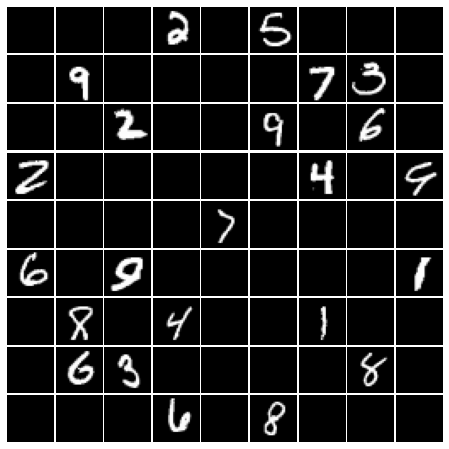

In [77]:
e = 0 # empty cell
sample_sudoku_grid = np.array([
    [e, e, e,  2, e, 5,  e, e, e],
    [e, 9, e,  e, e, e,  7, 3, e],
    [e, e, 2,  e, e, 9,  e, 6, e],

    [2, e, e,  e, e, e,  4, e, 9],
    [e, e, e,  e, 7, e,  e, e, e],
    [6, e, 9,  e, e, e,  e, e, 1],

    [e, 8, e,  4, e, e,  1, e, e],
    [e, 6, 3,  e, e, e,  e, 8, e],
    [e, e, e,  6, e, 8,  e, e, e]
])
visual_sudoku = sample_visual_sudoku(sample_sudoku_grid)
show_grid_img(visual_sudoku)


## Neural Network Classifier 

Convolutional Neural Networks (CNN) are the best for the digit classification task. We use the [LeNet](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) architecture, which uses two convolutional layers followed by two fully-connected layers. 

![](https://pytorch.org/tutorials/_images/mnist.png)

For convenience, this CNN was already pre-trained on MNIST training data

In [40]:
## Convolutional Neural Network for digit classification

from torch import nn 
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*16) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

def load_classifier(clf_classname, path):
    """
        Initialize a new CNN classifier by
        loading pre-trained weights stored in `path` file
    """
    net = clf_classname()
    state_dict = torch.load(path, map_location=lambda storage, loc: storage)
    net.load_state_dict(state_dict)
    return net

@torch.no_grad()
def predict_proba_sudoku(neuralnet, vizsudoku):
    """
        Assign a probabilistic vector to each image of the visual puzzle
    """
    grid_shape = vizsudoku.shape[:2]
    # reshape from 9x9x1x28x28 to 81x1x28x28 
    pred = neuralnet(vizsudoku.flatten(0,1))
    # our NN return 81 probabilistic vector: an 81x10 matrix
    return pred.reshape(*grid_shape,10).detach().numpy() # reshape as 9x9x10 tensor for easier visualisation

# load pre-trained classifier
cnn = load_classifier(LeNet,'lenet_mnist_e5_lr1e-5.pt') #TODO host elsewhere and load from url



Let's define helper function to visualize an input image and its output probability distribution

Predicted Digit = 6 	Actual = 6
Predicted Digit = 9 	Actual = 7


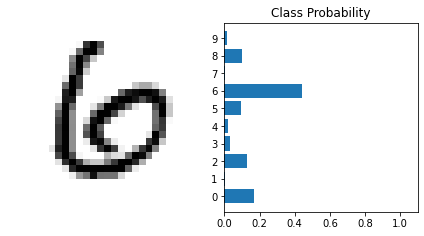

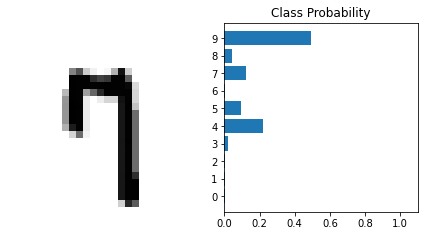

In [41]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze(), cmap='gray_r');
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

@torch.no_grad() # turn off gradients calculation
def show_one_prediction(model, data, i=0):
    img, label = data[i]
    logps = model(img.unsqueeze(0))
    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    view_classify(img, ps)
    print("Predicted Digit =", probab.index(max(probab)), "\tActual =",label)

# visualize how well our current CNN can accurately classify images
show_one_prediction(cnn, testset, 11)
show_one_prediction(cnn, testset, 80)

Both figures abive show that our pretrained CNN classifier is rather weak and lacks confidence in its predictions. It classifies the first image correctly but also hesitates between a 2 and a 0. In the second case, the network wrongly classifies the 7 has a 9. Those misclassifcations have a dramatic consequence when we use this CNN to solve a Visual Sudoku.  

## Visual Sudoku Solver in CPMpy 

Now we build a model in CPMpy to solve the Visual Sudoku Problem. Throughout this notebook, aside from the visual puzzle, we assume that we also which cells contains an image (givens) and which cells are blank (value has to be found by the solver). 


In [55]:
# Sudoku modeling  

def model_sudoku(grid):
    '''
        Build a model for standard Sudoku by creating 81 Intvars (one per cell) and 
        posting standard Sudoku constraints on row, columns and 3x3 blocks.
    '''
    n = len(grid)
    b = np.sqrt(n).astype(int)

    # decision vars
    puzvar = IntVar(1,n, shape=grid.shape, name='cell')

    # alldiff constraints
    constraints = []
    constraints += [alldifferent(row) for row in puzvar]
    constraints += [alldifferent(col) for col in puzvar.T]

    for i in range(0,n,b):
        for j in range(0,n,b):
            constraints += [alldifferent(puzvar[i: i +b, j:j+b])]

    model = Model(constraints)
    # we need access to decision vars later on
    return puzvar, model

def pretty_print_sudoku(grid, add_marker=None):
    """
        Helper function to print a numerical sudoku puzzle  
    """
    n = grid.shape[0]
    b = np.sqrt(n)
    out = ""
    for r in range(0,n):
        for c in range(0,n):
            out += str(grid[r,c])
            out += '* ' if add_marker is not None and add_marker[r,c] else '  '
            if (c+1) % b == 0 and c != n-1: # end of block
                out += '| '
        out += '\n'
        if (r+1) % b == 0 and r != n-1: # end of block
            out += ('-'*n)+'+-'+('-'*n)+'+'+('-'*n)+'\n'
    print(out)

In [56]:
# convolutional neural network predictions 
predictions = predict_proba_sudoku(cnn, visual_sudoku)
print("probability tensor of shape ", predictions.shape)

# boolean matrix which tells if a cell contains an image or not
is_given = sample_sudoku_grid > 0

print('Which cells are clues?\r')
pretty_print_sudoku(is_given.astype(int))

probability tensor of shape  (9, 9, 10)
Which cells are clues?
0  0  0  | 1  0  1  | 0  0  0  
0  1  0  | 0  0  0  | 1  1  0  
0  0  1  | 0  0  1  | 0  1  0  
---------+----------+---------
1  0  0  | 0  0  0  | 1  0  1  
0  0  0  | 0  1  0  | 0  0  0  
1  0  1  | 0  0  0  | 0  0  1  
---------+----------+---------
0  1  0  | 1  0  0  | 1  0  0  
0  1  1  | 0  0  0  | 0  1  0  
0  0  0  | 1  0  1  | 0  0  0  




## Naive Approach

The intuitive way to solve this problem is to proceed in a purely sequential way:

1. For each given, take the most likely label as a deterministic input
2. Then solve the resulting Sudoku puzzle with CP. 


In [82]:
def solve_vizsudoku_naive(puzvar, model, logprobs, is_given):
    """
        Baseline: take most likely digit as deterministic input
    """
    most_likely = np.argmax(logprobs, axis=-1)
    model += [puzvar[is_given] == most_likely[is_given]]
    if model.solve() is not False:
        return puzvar.value()
    else:
        # unsatisfiable, we return a board of 0's 
        return np.zeros_like(puzvar)


Let's see how our CNN performs when we only consider maximum-likelihood predictions across the given cells. 

Maximum-likelihood predictions from the CNN
0  0  0  | 2  0  3* | 0  0  0  
0  2* 0  | 0  0  0  | 9* 3  0  
0  0  2  | 0  0  2* | 0  6  0  
---------+----------+---------
2  0  0  | 0  0  0  | 4  0  9  
0  0  0  | 0  7  0  | 0  0  0  
6  0  9  | 0  0  0  | 0  0  1  
---------+----------+---------
0  8  0  | 4  0  0  | 1  0  0  
0  6  3  | 0  0  0  | 0  8  0  
0  0  0  | 6  0  8  | 0  0  0  



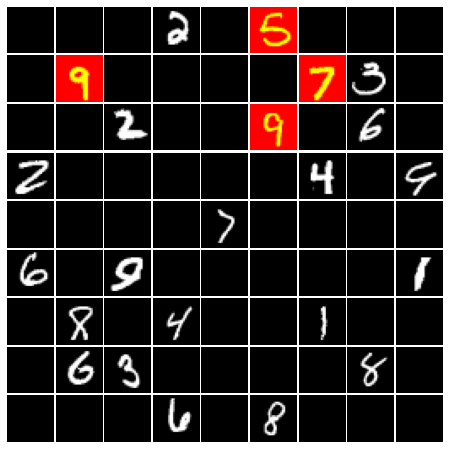

In [93]:
most_likely_label = np.argmax(predictions, axis=-1)
# boolean matrix to mark each wrong classification
wrong_label = most_likely_label != sample_sudoku_grid 
print('Maximum-likelihood predictions from the CNN')
pretty_print_sudoku(most_likely_label, wrong_label)
#show_grid_img(visual_sudoku, in_red=wrong_label)

In the current visual puzzle, four images are wrongly classified by the neural network (shown in red in the figure above). This would prevent the solver from finding a solution, using a standard Sudoku model. 

In [86]:
# Errors from the CNN lead to an infeasile sudoku. 
# We expect our naive approach to fail to find any solution
puzvar, model = model_sudoku(is_given)
solution_naive = solve_vizsudoku_naive(puzvar, model, predictions, is_given)
print('Satifiable?', not np.all(solution_naive==0))

Satifiable? False


## Maximum Likelihood Approach

The solver can correct misclassifications because they disregard Sudoku constraints.
Hence, the solver should reason over probabilities given by the CNN. 
To that end, we need to turn the satisfaction problem of sudoku into an optimisation problem, where we optimize for maximum log likelihood [[1]](#1). 

This means adding the following objective function: a weighted sum of the decision variables. Each weight is the log-probability of that decision variable being equal to the corresponding predicted value. 

### References 
<a id="1">[1]</a>
Mulamba, M., Mandi, J., Canoy, R., and Guns, T. (2020, September). Hybrid classification and reasoning for image-based constraint solving. In International Conference on Integration of Constraint Programming, Artificial Intelligence, and Operations Research (pp. 364-380). Springer, Cham.

In [91]:
# constant to turn float into int
PRECISION = 1e-4

def solve_vizsudoku_max_likelihood(model, puzvar, logprobs, is_given):
    '''
        Hyrbid 1 approach, as described in https://arxiv.org/pdf/2003.11001.pdf

        We add an objective function, turning the satisfaction problem into an optimisation problem.
        The goal is to find the feasible solution which maximizes the joint log-likelihood accross all givens. 

        The objective function is a weighted sum of the decision variables for givens,
         with as weight the log-probability of that decision variable being equal to the corresponding predicted value
    '''
    # divide by PRECISION to turn logprobs into integers. 
    lprobs = np.array(-logprobs/PRECISION).astype(int)

    # objective function: max log likelihood prediction for givens
    # (probability vector indexed by an integer decision variable) 
    obj = sum(Element(lp, v) for lp,v in zip(lprobs[is_given], puzvar[is_given]))

    # Because we have log-probabilities, we flip the sign to only have positives 
    # Hence the optimisation becomes a minimisation problem
    model.minimize(obj)

    if model.solve() is not False:
        return puzvar.value()
    else:
        return np.zeros_like(puzvar)

In [108]:

## helper function to project the numerical solution onto the visual space
def project_numeric_to_visual(numerical_solution, numerical_puzzle, visual_puzzle, is_given):
    """
        Build a visual version of the `numerical_solution`, by filling in empty cells in
        the `visual_puzzle´ with MNIST images
    """
    images = (255 * visual_puzzle).int().numpy()

    # project same images as in the visual puzzle, on cell whose value did not change
    visual_solution = torch.zeros_like(visual_puzzle)# np.zeros_like(images)
    #same_digits = numerical_solution == numerical_puzzle
    visual_solution[is_given,:,:,:] = visual_puzzle[is_given,:,:,:]

    visual_solution = visual_solution.reshape(-1, N_CHANNEL, IMAGE_WIDTH, IMAGE_HEIGHT)
    #same_digits = same_digits.flatten()
    # sample the rest from MNIST 
    for i, given in np.ndenumerate(is_given.flatten()):
        if not given:
            # sample from MNIST
            val = numerical_solution.flatten()[i]
            img,_ = testset[digit_indices[val][0]]
            visual_solution[i,:,:,:] = img
    return visual_solution.reshape(numerical_solution.shape + (N_CHANNEL, IMAGE_WIDTH, IMAGE_HEIGHT))



5  9  6  | 2  4  3* | 7  1  8  
1  4* 8  | 7  6  5  | 9* 3  2  
3  7  2  | 8  1  9* | 5  6  4  
---------+----------+---------
2  1  7  | 3  8  6  | 4  5  9  
8  5  4  | 9  7  1  | 6  2  3  
6  3  9  | 5  2  4  | 8  7  1  
---------+----------+---------
7  8  5  | 4  3  2  | 1  9  6  
4  6  3  | 1  9  7  | 2  8  5  
9  2  1  | 6  5  8  | 3  4  7  



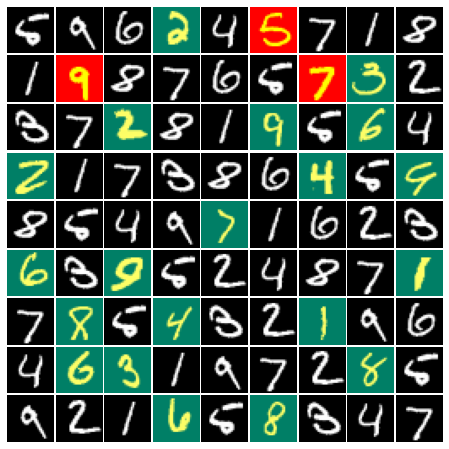

In [110]:
# Let's solve the visual sudoku with the hybrid approach
puzvar, model = model_sudoku(is_given)
solution_max_likelihood = solve_vizsudoku_max_likelihood(model, puzvar, predictions, is_given)
visual_max_likely = project_numeric_to_visual(solution_max_likelihood, sample_sudoku_grid, visual_sudoku, is_given)

# print the output of the hybrid approach
pretty_print_sudoku(solution_max_likelihood, wrong_label)
corrected_label = solution_max_likelihood == sample_sudoku_grid 
show_grid_img(visual_max_likely, in_red=wrong_label, in_green=corrected_label)


This maximum likelihood formulation looks better, as it actually finds a feasible solution, whereas using the naive approach did not get us anywhere. Among images that are misclassified by the CNN, 3 out of 4 remain so.  